# First NN with PyTorch on Tabular Data

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics # plot_roc_curve.
from sklearn.model_selection import train_test_split # Train/test/validation split of data.
import sklearn.preprocessing as preprocessing
import patsy # Is not needed anylonger since sklearn did what I wanted.
import random 

# Pytorch imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader # Not sure what "Dataset" is for atm.

# Configure the device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using '{device}' device.")

# Print working directory (for control)
import os
print(f"The working directory is {os.getcwd()}")

# Set seeds for reproducibility. 
seed = 1234
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

Using 'cuda' device.
The working directory is /home/ajo/gitRepos/master_thesis


## Load the Adult census data and pre-process a little

In [11]:
# df1 = pd.read_csv("original_data/adult.data", header = None, na_values = " ?")
# df2 = pd.read_csv("original_data/adult.test", header = None, na_values = " ?")
# df1.columns = df2.columns = ["age","workclass","fnlwgt","education","education_num",
#                       "marital_status","occupation","relationship","race","sex",
#                       "capital_gain","capital_loss","hours_per_week","native_country", "y"]
# adult_data = pd.concat([df1,df2], ignore_index = True)

# categorical_features = ["workclass","marital_status","occupation","relationship", \
#                          "race","sex","native_country"]
# numerical_features = ["age","fnlwgt","education_num","capital_gain","capital_loss","hours_per_week"]

# # Remove "education" column.
# adult_data = adult_data.drop(columns = ["education"])

# # Check if there are any NA values. 
# print(adult_data.shape)
# print(adult_data.isnull().values.any())
# adult_data = adult_data.dropna() # Drop the NA values since we know they are few for this data set. 
# print(adult_data.shape)

# # Select covariates and response. 
# X = adult_data.loc[:, adult_data.columns != "y"]
# y1 = adult_data.loc[:,"y"] # Temporary data frame. 
# y = y1.copy()

# # Change y such that " <=50K"=0 and " >50K"=1
# y.loc[y == " <=50K"] = 0
# y.loc[y == " <=50K."] = 0
# y.loc[y == " >50K"] = 1
# y.loc[y == " >50K."] = 1


# # Get some more info about the levels in the categorical features below. 
# summer = 0
# lens_categorical_features = []
# for feat in categorical_features:
#     unq = len(X[feat].value_counts().keys().unique())
#     print(f"Feature '{feat}'' has {unq} unique levels")
#     lens_categorical_features.append(unq)
# print(f"The sum of all levels is {sum(lens_categorical_features)}. This will be the number of cat-columns after one-hot encoding (non-full rank)")
# print(lens_categorical_features)
# # We save the complete data set as a csv for use in other scripts.
# adult_for_saving = X.copy()
# adult_for_saving["y"] = y
# adult_for_saving.to_csv("adult_data_no_NA.csv") # Save this 

(48842, 14)
True
(45222, 14)
Feature 'workclass'' has 7 unique levels
Feature 'marital_status'' has 7 unique levels
Feature 'occupation'' has 14 unique levels
Feature 'relationship'' has 6 unique levels
Feature 'race'' has 5 unique levels
Feature 'sex'' has 2 unique levels
Feature 'native_country'' has 41 unique levels
The sum of all levels is 82. This will be the number of cat-columns after one-hot encoding (non-full rank)
[7, 7, 14, 6, 5, 2, 41]


## Pre-processing of data

This is done in my Data class "automatically".

* One-hot encoding of categorical features.
* Train/test/validation split.
* Standardization of numerical features (first in training data, then in testing and validation with the same center and scale.

In [275]:
# # Thus, instead of patsy, we use Sklearn's OneHotEncoder. 
# # Eventually, we could and chould make a class for data preprocessing.

# def fit_encoder(df):
#     return preprocessing.OneHotEncoder(handle_unknown = "error", sparse = False, drop = None).fit(df)

# one_hot_encoder = fit_encoder(X[categorical_features]) # Fit the encoder to the categorical data.
# X_onehot = X.copy() # Deep copy the X-data. 

# encoded_features = one_hot_encoder.get_feature_names(categorical_features) # Get the encoded names. 

# # Add the new columns to the new dataset (all the levels of the categorical features).
# X_onehot[encoded_features] = one_hot_encoder.transform(X_onehot[categorical_features])

# # Remove the old columns (before one-hot encoding)
# X_onehot = X_onehot.drop(categorical_features, axis = 1) 
# print(X_onehot.shape) # Shape is correct!

In [276]:
# # Train/test/validation split.
# X_train, X_test, y_train, y_test = train_test_split(X_onehot, y, test_size=1/3, random_state=42)
# X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=1/3, random_state=42)
# print(X_train.shape) # 2/3
# print(X_test.shape) # 2/9
# print(X_valid.shape) # 1/9

In [277]:
# # Standardization. We standardize according to the training data!

# def fit_scaler(df):
#     return preprocessing.StandardScaler().fit(df)
#     # could also use the quantile transformer!

# # Fit the scaler to the training data to acquire correct center and scale.
# standard_scaler = fit_scaler(X_train[numerical_features]) 

# def scale(df,standard_scaler):
#     output = df.copy()
#     output[numerical_features] = standard_scaler.transform(output[numerical_features])
#     return output

# def descale(df,standard_scaler):
#     output = df.copy()
#     output[numerical_features] = standard_scaler.inverse_transform(output[numerical_features])
#     return output

# # Check if the means and scales of each of the columns are correct. 
# # Use this to standardize the validation and testing data as well. 
# print(standard_scaler.mean_)
# print(standard_scaler.scale_)

# print(X_train["age"].mean(), X_train["age"].std())
# print(X_train["fnlwgt"].mean(), X_train["fnlwgt"].std())
# print(X_train["education_num"].mean(), X_train["education_num"].std())
# # The scales are not completely correct! Not sure why?

# # Standardize the two other data sets according to the same centering/scaling as the training data. 
# X_train2 = scale(X_train, standard_scaler)
# X_train3 = descale(X_train2, standard_scaler)
# plt.hist(X_train2["age"], label = "Stand")
# plt.hist(X_train3["age"], label = "Back")
# plt.hist(X_train["age"], label = "OG", alpha = 0.3)
# plt.title("Hist of Age")
# plt.legend() # Seems to work fine!

In [278]:
# # Standardize the training data.
# X_train = scale(X_train, standard_scaler)

# # Standardize the testing data.
# X_test = scale(X_test, standard_scaler)

# # Standardize the validation data.
# X_valid = scale(X_valid, standard_scaler)

In [279]:
# X_train[numerical_features].describe()

In [280]:
# descale(X_train, standard_scaler)[numerical_features].describe()

## Dataset and Dataloader from Pytorch

In [281]:
# Load the adult data. 
adult_data = pd.read_csv("adult_data_no_NA.csv", index_col = 0)

# Load the Data class.
#from Data import Data # Fungerer ikke å importere på denne måten tydeligvis!?

# Make Data object for Adult data. 
#Adult = Data(adult_data, categorical_features, numerical_features, valid = True)

# Get training, testing and validation data.
#X_train, y_train = Adult.get_training_data()
#X_test, y_test = Adult.get_test_data()
#X_valid, y_valid = Adult.get_validation_data()

In [282]:
# Could load the code using the magick command below. 
# %load Data.py
# Classes for data.

class Data():
    """Class for pre-processing data. It automatically encodes, splits and scales the data. 
    
    Contains methods for standardization, encoding and train/test/validation splitting.
    
    Parameters
    ----------
    data : dataframe
        Pandas df with loaded data. 
    cat_features : list of strings.
        List of categorical features. 
    num_features : list of string. 
        List of numerical features. 
    valid : Boolean 
        True if validation data should be made, False if not. 
        
    Methods 
    -------
    get_training_data :
        Returns a tuple with training data (X,y).
    get_test_data :
        Returns a tuple with test data (X,y).   
    get_validation_data :
        Returns a tuple with validation data (X,y) (if applicable).
    train_test_valid_split : 
        Returns a tuple with (X_train, y_train, X_test, y_test) or 
        (X_train, y_train, X_test, y_test, X_valid, y_valid).
    scale : 
        Scale the numerical features according to X_train.
    descale : 
        Descale the numerical features according to X_train.
    fit_scaler :
        Fit sklearn scaler to X_train.
    encode :
        Encode the categorical features according to X_train.
    decode :
        Decode the categorical features according to X_train.
    fit_encoder :
        Fit sklearn encoder to X_train.
        
    """
    def __init__(self, data, cat_features, num_features, valid = False):
        # The transformations are then done here. 
        self._data = data
        self.categorical_features = cat_features
        self.numerical_features = num_features
        self.valid = valid
        
        # Assume output always is called 'y'.
        self._X = data.loc[:, data.columns != "y"]
        self._y = data.loc[:,"y"] 
        
        # Encode the categorical features. 
        self.encoder = self.fit_encoder() # Fit the encoder to the categorical data.
        self.X_encoded = self.encode()
        
        # Split into train/test/valid.
        if self.valid:
            (self.X_train, self.y_train, self.X_test, self.y_test, \
                self.X_valid, self.y_valid) = self.train_test_valid_split(self.X_encoded, self._y)
        else:
            (self.X_train, self.y_train, self.X_test, self.y_test) = self.train_test_valid_split(self.X_encoded, self._y)
        
        
        # Scale the numerical features. 
        self.scaler = self.fit_scaler()
        self.X_train = self.scale(self.X_train) # Scale the training data.
        self.X_test = self.scale(self.X_test) # Scale the test data.
        if self.valid:
            self.X_valid = self.scale(self.X_valid) # Scale the validation data. 
        
    
    def get_training_data(self):
        """Returns training data (X_train, y_train)."""
        return self.X_train, self.y_train
    
    def get_test_data(self):
        """Returns test data (X_test, y_test)."""
        return self.X_test, self.y_test
    
    def get_validation_data(self):
        """Returns validation data (X_valid, y_valid) if applicable."""
        if self.valid:
            return self.X_valid, self.y_valid
        else: 
            raise ValueError("You did not instantiate this object to contain validation data.")
    
    def train_test_valid_split(self, X, y):
        """Split data into training/testing/validation, where validation is optional at instantiation."""
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)
        if self.valid:
            X_test, X_valid, y_test, y_valid = train_test_split( \
                                        X_test, y_test, test_size=1/3, random_state=42)
            return (X_train, y_train, X_test, y_test, X_valid, y_valid)
        return (X_train, y_train, X_test, y_test)
            
    def scale(self, df):
        """Scale the numerical features according to the TRAINING data."""
        output = df.copy() # Deep copy the given df. 
        output[self.numerical_features] = self.scaler.transform(output[self.numerical_features])
        return output
        
    def descale(self, df):
        """Descale the numerical features according to the TRAINING data."""
        output = df.copy()
        output[self.numerical_features] = self.scaler.inverse_transform(output[self.numerical_features])
        return output

    def fit_scaler(self):
        """Fit the scaler to the numerical TRAINING data. Only supports OneHotEncoding."""
        return preprocessing.StandardScaler().fit(self.X_train[self.numerical_features])
    
    def encode(self):
        """Encode the categorical data. Only supports OneHotEncoding."""
        output = self._X.copy() # Deep copy the X-data.
        encoded_features = self.encoder.get_feature_names(self.categorical_features) # Get the encoded names. 
        
        # Add the new columns to the new dataset (all the levels of the categorical features).
        output[encoded_features] = self.encoder.transform(output[self.categorical_features])

        # Remove the old columns (before one-hot encoding)
        output = output.drop(self.categorical_features, axis = 1) 
        return output
    
    def decode(self, df):
        """Decode the categorical data. Only support OneHotEncoding."""
        output = df.copy()
        encoded_features = self.encoder.get_feature_names(self.categorical_features) # Get the encoded names. 
        
        if len(encoded_features) == 0:
            return output # Does not work when there are not categorical features in df.
        
        output[self.categorical_features] = self.encoder.inverse_transform(output[encoded_features])
        output = output.drop(encoded_features, axis=1)
        return output
    
    def fit_encoder(self):
        """Fit the encoder to the categorical data. Only supports OneHotEncoding."""
        return preprocessing.OneHotEncoder(handle_unknown = "error", \
          sparse = False, drop = None).fit(self._X[self.categorical_features])
    


In [283]:
# Could also run the file like this directly (into memory).
%run Data.py

In [284]:
Adult = Data(adult_data, categorical_features, numerical_features, valid = True)
X_train, y_train = Adult.get_training_data()
X_test, y_test = Adult.get_test_data()
X_valid, y_valid = Adult.get_validation_data()

In [285]:
# This can be done as below (for example).

class CustomDataset(Dataset):
    
    def __init__(self, X, y, transform = None, valid = True):
        # Could load the Adult data directly in here. Or could take X, y from Adult data loaded earlier. 
        self.X = X.values.astype(np.float32) # Return a Numpy array with the dataframe contents. 
        self.y = np.reshape(y.values,(len(y.values),1)).astype(np.float32) # Return a Numpy array with the dataframe contents. 
        # Needed to reshape a little above, check that this is correct later!
        
        # use the methods defined below to split the data, scale and one-hot encode directly
        # in the constructor (very smooth!)
        
        self.n_samples = self.X.shape[0]
        self.transform = transform
       
    def __getitem__(self, index):
        sample = self.X[index], self.y[index]
        #return sample
        if self.transform:
            sample = self.transform(sample)
        return sample
   
    def __len__(self):
        return self.n_samples
    
    # Could add a lot more of the preprocessing of the data to this class eventually!
    
    def train_test_valid_split(self, valid=True):
        #split the data into train/test and validation (optional)
        pass
            
    
    def scale(self):
        #scale the numerical data according to the training data. 
        pass
    
    def descale(self):
        #descale the numerical data according to the training data. 
        pass

    def fit_scaler(self):
        #fit the numerical data scaler according to the training data. 
        pass
    
    def encode(self):
        #encode the categorical data (one-hot for now)
        pass
    
    def decode(self):
        #decode the categorical data (from one-hot)
        pass
    
    def fit_encoder(self):
        #fit the encoder to the categorical data features. 
        pass
    
class ToTensor: # Transform to Pytorch tensors. 
    def __call__(self, sample):
        inputs, labels = sample
        #print(labels)
        return torch.from_numpy(inputs), torch.from_numpy(labels)


# select rows from the dataset
train_data = CustomDataset(X_train, y_train, transform = ToTensor()) # Here we put the Adult data loaded in earlier cells into the Dataset type. 

# Check if it works as expected.
nex = train_data[0]
print(nex)
print(type(nex[0]), type(nex[1]))

(tensor([-1.4003, -0.2451, -0.0485, -0.1451, -0.2180, -1.9924,  0.0000,  0.0000,
         1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000]), tensor([0.]))
<class 'torch.Tensor'> <class 'torch.Tensor'>


## Build the Simple Classifier

The classifier will have three dense layers with 18, 9 and 3 units respectively. In addition, it will use ReLU activations in each of the layers and have a sigmoid output activation, since we want to do binary classification of the output.

In [286]:
# Set the hyperparameters.
input_size = X_test.shape[1] # Number of columns in the data.

# Could have used Pytorch sequential for this.
class NeuralNet(nn.Module):
    def __init__(self, input_size):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        
        # Layers. 
        self.l1 = nn.Linear(input_size, 18)
        self.l2 = nn.Linear(18,9)
        self.l3 = nn.Linear(9,3)
        self.output = nn.Linear(3,1)
        
        # Activation functions.
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        out = self.relu(out)
        out = self.l3(out)
        out = self.relu(out)
        out = self.output(out)
        out = self.sigmoid(out) 
        return out

model = NeuralNet(input_size).to(device) # Load the neural net onto the gpu.
print(model) # Have a look at the neural network.

NeuralNet(
  (l1): Linear(in_features=88, out_features=18, bias=True)
  (l2): Linear(in_features=18, out_features=9, bias=True)
  (l3): Linear(in_features=9, out_features=3, bias=True)
  (output): Linear(in_features=3, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


## Train the model.

In [287]:
# Some hyperparameters for training. 
num_epochs = 30
batch_size = 1024
learning_rate = 0.01

criterion = nn.BCELoss() # Loss function.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

# Data for the training. 
train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers = 2)

# Train the model.
n_total_steps = len(train_loader) # Total length of training data. 
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Data for validation.
val_dat = torch.from_numpy(X_valid.values.astype(np.float32)).to(device)
val_labs = torch.from_numpy(y_valid.values.astype(np.float32)).to(device)
val_labs = val_labs.view(val_labs.shape[0],1)
# The training takes a very long time when we do validation on the entire validation data set like here!
# Should do it differently! Do later. 

for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):  
        # Load the data on to the gpu.
        inputs = inputs.to(device)
        y_acc_metric = labels.reshape(-1).numpy() # Used to measure accuracy as a metric below. 
        labels = labels.view(labels.shape[0],1).to(device) 
        
        # Forward pass.
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Accuracy metric reporting. 
        accuracy = (outputs.reshape(-1).cpu().detach().numpy().round() == y_acc_metric).mean()
        
        # We also want to report some validation metrics (on validation data).
        #val_preds = model(val_dat)
        #val_loss = criterion(val_preds, val_labs)
        #val_accuracy = (val_preds.reshape(-1).cpu().detach().numpy().round() \
        #                == np.reshape(y_valid.values,(len(y_valid.values),1))).mean()
        
        # Backward and optimize.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        if (i+1) % 10 == 0:
            train_losses.append(loss.item())
            train_accuracies.append(accuracy)
            #val_losses.append(val_loss)
            #val_accuracies.append(val_accuracy)
            #print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}, ValLoss: {val_loss.item():.4f}, Acc: {accuracy:.4f}, ValAcc: {val_accuracy:.4f}')
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}, Acc: {accuracy:.4f}')

Epoch [1/30], Step [10/30], Loss: 0.6422, Acc: 0.7529
Epoch [1/30], Step [20/30], Loss: 0.5602, Acc: 0.7891
Epoch [1/30], Step [30/30], Loss: 0.3935, Acc: 0.8119
Epoch [2/30], Step [10/30], Loss: 0.3640, Acc: 0.8281
Epoch [2/30], Step [20/30], Loss: 0.3251, Acc: 0.8564
Epoch [2/30], Step [30/30], Loss: 0.3370, Acc: 0.8341
Epoch [3/30], Step [10/30], Loss: 0.3410, Acc: 0.8418
Epoch [3/30], Step [20/30], Loss: 0.3206, Acc: 0.8486
Epoch [3/30], Step [30/30], Loss: 0.3046, Acc: 0.8363
Epoch [4/30], Step [10/30], Loss: 0.2878, Acc: 0.8711
Epoch [4/30], Step [20/30], Loss: 0.2954, Acc: 0.8555
Epoch [4/30], Step [30/30], Loss: 0.3657, Acc: 0.8097
Epoch [5/30], Step [10/30], Loss: 0.3474, Acc: 0.8447
Epoch [5/30], Step [20/30], Loss: 0.3272, Acc: 0.8359
Epoch [5/30], Step [30/30], Loss: 0.3412, Acc: 0.8540
Epoch [6/30], Step [10/30], Loss: 0.3139, Acc: 0.8438
Epoch [6/30], Step [20/30], Loss: 0.3253, Acc: 0.8418
Epoch [6/30], Step [30/30], Loss: 0.3148, Acc: 0.8562
Epoch [7/30], Step [10/30], 

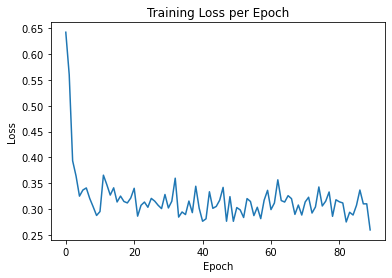

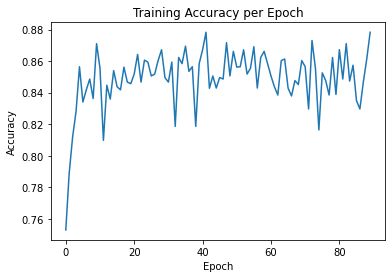

In [288]:
plt.plot(train_losses)
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.plot(train_accuracies)
plt.title("Training Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [289]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
test_data = CustomDataset(X_test, y_test, transform = ToTensor())
test_loader = DataLoader(test_data, batch_size = batch_size, shuffle = False, num_workers = 2)

test_steps = len(test_loader)
test_accuracies = []
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for i, (inputs, labels) in enumerate(test_loader):
        # Load the data on to the gpu.
        inputs = inputs.to(device)
        y_acc_metric = labels.reshape(-1).numpy() # Used to measure accuracy as a metric below. 
        
        # Forward pass.
        outputs = model(inputs)
        #print(outputs)
        
        # Accuracy metric reporting. 
        accuracy = (outputs.reshape(-1).cpu().detach().numpy().round() == y_acc_metric).mean()
        
    
        test_accuracies.append(accuracy)
        print (f'Step [{i+1}/{test_steps}], Acc: {accuracy:.4f}')
        
print(f"Average test accuracy over all batches: {sum(test_accuracies)/len(test_accuracies):.4f}")

Step [1/10], Acc: 0.8584
Step [2/10], Acc: 0.8613
Step [3/10], Acc: 0.8643
Step [4/10], Acc: 0.8633
Step [5/10], Acc: 0.8457
Step [6/10], Acc: 0.8516
Step [7/10], Acc: 0.8525
Step [8/10], Acc: 0.8574
Step [9/10], Acc: 0.8369
Step [10/10], Acc: 0.8391
Average test accuracy over all batches: 0.8531


Unique predicted values: [2.1198730e-05 2.5203130e-05 2.7043267e-05 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]


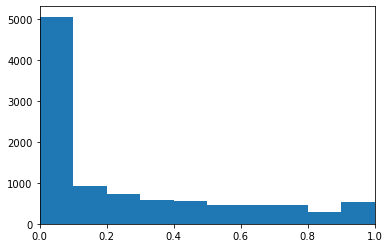

In [290]:
# Test on entire test data set at once.
with torch.no_grad():
    test_dat = torch.from_numpy(X_test.values.astype(np.float32)).to(device)
    test_labs = torch.from_numpy(y_test.values.astype(np.float32))
    test_labs = test_labs.view(test_labs.shape[0],1)
    
    predicted_probs = model(test_dat).cpu().numpy()
    
    plt.hist(predicted_probs.flatten())
    plt.xlim(0,1)
    print(f"Unique predicted values: {np.unique(predicted_probs.flatten())}")

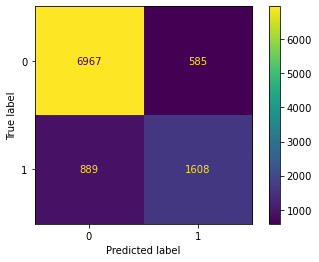

Some more classifaction statistics:
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      7552
           1       0.73      0.64      0.69      2497

    accuracy                           0.85     10049
   macro avg       0.81      0.78      0.80     10049
weighted avg       0.85      0.85      0.85     10049



In [291]:
# Confusion matrix.
labs = list(y_test.values)
preds = predicted_probs.flatten()
predicted_classes = np.where(preds > 0.5, 1, 0)
cm = metrics.confusion_matrix(labs, list(predicted_classes), labels = [0,1])
conf_mat = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
conf_mat.plot()
plt.show()

print("Some more classifaction statistics:")
print(metrics.classification_report(labs, predicted_classes, labels = [0,1]))

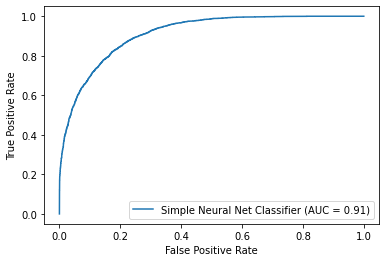

In [292]:
# Make roc and auc below. 
fpr, tpr, thresholds = metrics.roc_curve(labs, predicted_probs.flatten())
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                   estimator_name='Simple Neural Net Classifier')
display.plot()
plt.show()

## Now we select 100 "negatively" predicted individuals at random, to explain later.

In [293]:
K = 100

# We add the predicted labels to the testing dataframe. 
test_data_full = X_test.copy()
test_data_full["y_true"] = y_test # add true outputs. 
test_data_full["y_pred"] = predicted_classes # add predicted outputs. 

# Dataframe of 100 individuals negatively predicted by the classifier. 
H = test_data_full[test_data_full["y_pred"] == 0].sample(n = K, axis = 0)
H.to_csv("H_adult.csv") # Save this 

In [294]:
# In case I want to save the trained model.
PATH = './mymodel.pth'
#torch.save(model.state_dict(), PATH)

In [295]:
# Load the weights and biases (with the same structure as the model used here).
# The model class needs to be saved somewhere, because pickle saves a path to the file containing the class, which is used during load time. 
#model = NeuralNet(input_size).to(device)
#model.load_state_dict(torch.load(PATH))

# A few simple beginning tutorials are given below 

* [this](https://www.datacamp.com/tutorial/pytorch-tutorial-building-a-simple-neural-network-from-scratch)
* [this](https://medium.com/analytics-vidhya/a-simple-neural-network-classifier-using-pytorch-from-scratch-7ebb477422d2)
* [this](https://medium.com/analytics-vidhya/pytorch-for-deep-learning-binary-classification-logistic-regression-382abd97fb43).
